<a href="https://colab.research.google.com/github/faishalwickson/COVID-Cases-Forecasting-Based-on-Mobility-Using-Prophet/blob/main/covid_mobility_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# access API
import requests
import urllib.request
from bs4 import BeautifulSoup
import re
import json

# BPS Java-Bali Covid Cases

## Extract

In [2]:
# sub region list
province = ['DKI_JAKARTA', 'JAWA_BARAT', 'JAWA_TIMUR', 'JAWA_TENGAH', 'SULAWESI_SELATAN',
            'BANTEN', 'NUSA_TENGGARA_BARAT', 'BALI', 'PAPUA', 'KALIMANTAN_SELATAN',
            'SUMATERA_BARAT', 'SUMATERA_SELATAN', 'KALIMANTAN_TENGAH', 'KALIMANTAN_TIMUR',
            'SUMATERA_UTARA', 'DAERAH_ISTIMEWA_YOGYAKARTA', 'KALIMANTAN_UTARA',
            'KEPULAUAN_RIAU', 'KALIMANTAN_BARAT', 'SULAWESI_TENGGARA', 'LAMPUNG',
            'SULAWESI_UTARA', 'SULAWESI_TENGAH', 'RIAU', 'PAPUA_BARAT', 'SULAWESI_BARAT',
            'JAMBI', 'GORONTALO', 'MALUKU_UTARA', 'MALUKU', 'KEPULAUAN_BANGKA_BELITUNG',
            'ACEH', 'BENGKULU', 'NUSA_TENGGARA_TIMUR']

# dummy arrays
resp = [None]*len(province)
cov_data = []
data_covid = []
cov_raw = {}

In [3]:
# access API
df = []
for i in range(0, len(province)):
  resp = requests.get('https://data.covid19.go.id/public/api/prov_detail_'+province[i]+'.json')
  cov_raw = resp.json()
  covid = pd.DataFrame(cov_raw['list_perkembangan'])
  covid['province'] = [province[i]]*len(covid)
  df.append(covid)
  
results = pd.concat(df, ignore_index=True) # concatenate data of each province

# convert to date time
results['tanggal'] = pd.to_datetime(results['tanggal']*1e6, unit='ns')

## Transform

In [4]:
# tidy up data
results_tidy = (results.drop(columns=[item for item in results.columns if item.startswith('AKUMULASI') or item.startswith('DIRAWAT')])
                  .rename(columns=str.lower)
                  .rename(columns={'kasus':'y',
                                   'tanggal': 'ds',
                                   'meninggal': 'death',
                                   'sembuh': 'recovered'}))

In [5]:
# Filter the country region
for region in ['DKI_JAKARTA', 'JAWA_BARAT', 'BANTEN', 'JAWA_TENGAH','JAWA_TIMUR', 
               'DAERAH_ISTIMEWA_YOGYAKARTA', 'BALI']:
  temp = results_tidy.loc[results_tidy['province'].isin([region])]
  temp = temp.drop(['province'], axis=1) # drop column
  
  # saving dataframe
  if region in ['DKI_JAKARTA']: df_jkt = temp
  elif region in ['JAWA_BARAT']: df_jbr = temp
  elif region in ['BANTEN']: df_bnt = temp
  elif region in ['JAWA_TENGAH']: df_jtg = temp
  elif region in ['JAWA_TIMUR']: df_jtm = temp
  elif region in ['DAERAH_ISTIMEWA_YOGYAKARTA']: df_diy = temp
  elif region in ['BALI']: df_bli = temp

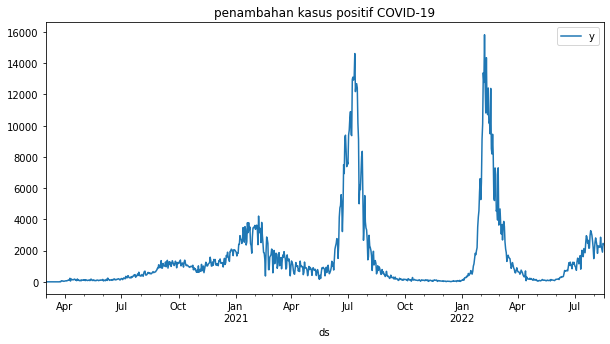

In [6]:
# visualize the data
df_jkt.plot(x='ds', y='y', figsize=(10,5), title="penambahan kasus positif COVID-19")

# Google Community Mobility

## Extract

In [7]:
# Import data
dataset = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', low_memory=False)

## Transform

In [8]:
# Filter the country region
dataset = dataset.loc[dataset['country_region'].isin(["Indonesia"])]

# dropping unnecessary fields
dataset = dataset.drop(['country_region_code', 'country_region',
                        'sub_region_2','metro_area', 'iso_3166_2_code',
                        'census_fips_code', 'place_id'], axis=1)

# Rename some columns
dataset = dataset.rename(columns={'date': 'ds',
                                  'retail_and_recreation_percent_change_from_baseline': 'retail_recreation',
                                  'grocery_and_pharmacy_percent_change_from_baseline': 'grocery_pharmacy',
                                  'parks_percent_change_from_baseline': 'parks',
                                  'transit_stations_percent_change_from_baseline': 'transit_stations',
                                  'workplaces_percent_change_from_baseline': 'workplaces',
                                  'residential_percent_change_from_baseline': 'residential'})

# Replace null values
dataset['sub_region_1'].fillna('')
for column in ['retail_recreation', 'grocery_pharmacy', 'parks', 
               'transit_stations', 'workplaces', 'residential']:
  dataset[column] = dataset[column].fillna(0)

# Adding information on country level
dataset.loc[dataset['sub_region_1'] == '', 'sub_region_1'] = '<All Regions>'

# Flatten the pivot table and reset the index of the dataframe 
dataset = pd.DataFrame(dataset.to_records()).reset_index(drop=True)
dataset.drop('index', inplace=True, axis=1)

# Convert data type for 'ds' to datetime
dataset['ds'] = pd.to_datetime(dataset['ds'], unit='ns')

In [9]:
# Filter the country region
for region in ['Jakarta', 'West Java', 'Banten', 'Central Java',
                            'East Java', 'Special Region of Yogyakarta', 'Bali']:
  temp = dataset.loc[dataset['sub_region_1'].isin([region])]
  temp = temp.drop(['sub_region_1'], axis=1) # drop column
  
  # saving dataframe
  if region in ['Jakarta']: jkt = temp 
  elif region in ['West Java']: jbr = temp
  elif region in ['Banten']: bnt = temp
  elif region in ['Central Java']: jtg = temp
  elif region in ['East Java']: jtm = temp
  elif region in ['Special Region of Yogyakarta']: diy = temp
  elif region in ['Bali']: bli = temp

# Data integration

In [10]:
# Merge dataset per province with google mobility
df_jkt = df_jkt.merge(jkt, how='inner', on='ds')
df_jbr = df_jbr.merge(jbr, how='inner', on='ds')
df_bnt = df_bnt.merge(bnt, how='inner', on='ds')
df_jtg = df_jtg.merge(jtg, how='inner', on='ds')
df_diy = df_diy.merge(diy, how='inner', on='ds')
df_jtm = df_jtm.merge(jtm, how='inner', on='ds')
df_bli = df_bli.merge(bli, how='inner', on='ds')

# Forecast

In [11]:
# !install -c conda-forge fbprophet -y

In [12]:
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from prophet import Prophet
from prophet import hdays
from prophet.diagnostics import cross_validation
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import warnings
warnings.warn("Warning...........Message")

import seaborn as sns

import logging
logging.getLogger().setLevel(logging.ERROR)

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
def MAPE(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))
def mdape(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.median(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))

In [13]:
regr = ['parks', 'workplaces', 'grocery_pharmacy', 'retail_recreation',
        'transit_stations', 'residential']
period = [30, 30, 21, 21, 21, 14, 7] # forecast period for next few days (changing)
h = 7 # moving average and holiday period
fcst = 'last period'

In [14]:
holidays_id = hdays.Indonesia()
holidays_id._populate(2020)
holidays_id._populate(2021)
holidays_id._populate(2022)
holiday = pd.DataFrame([holidays_id], index=['holiday']).T.rename_axis('ds').reset_index()
holiday['lower_window'] = 0
holiday['upper_window'] = h

cps = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.25]
sps = [10, 5, 1, 10, 5, 0.01, 0.01]
cr = [0.95, 0.8, 0.9, 0.8, 0.8, 0.8, 0.8]
front = [13, 15, 12, 12, 30, 20, 15]

In [15]:
dfs = [df_jkt, df_jbr, df_jtg, df_jtm, df_bnt, df_bli, df_diy]
for iter, df in enumerate(dfs):
  df = df.copy()
  for i, column in enumerate(df.columns[4:]):
    name = 'MA_'+column
    df[name] = df[column].rolling(h).mean()
    regr[i] = name
  df['y'] = df['y'].rolling(h).mean()
  df = df[front[iter]:].reset_index(drop=True)
  test = pd.concat([df, df[-1*period[iter]:]], ignore_index=True)

  data = df[['y']]
  data, lam = boxcox(df['y'])
  df['y'] = data

  m1 = Prophet(changepoint_prior_scale = cps[iter],
             changepoint_range = cr[iter],
             seasonality_prior_scale = sps[iter],
             seasonality_mode = 'additive',
             holidays = holiday)
  
  # add regressors to model
  for regressor in regr:
    m1.add_regressor(regressor, mode= 'multiplicative')
  
  # fit the model
  m1.fit(df)

  # create a dataframe holding dates for forecasting
  # periods length equal with test
  future = m1.make_future_dataframe(periods=period[iter], freq='D')

  # add future fields for regressors
  for regressor in regr:
    future[regressor] = test[regressor]
  
  # create the forecast object
  forecast = m1.predict(future)

  # invers forecast to actual scale
  for column in ['yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_upper', 'trend_lower']:
    forecast[column] = inv_boxcox(forecast[[column]], lam)
  m1.history['y'] = inv_boxcox(m1.history[['y']], lam)

  load = forecast[['ds', 'trend', 'extra_regressors_multiplicative', 'holidays',
                   'MA_grocery_pharmacy', 'MA_parks', 'MA_residential',
                   'MA_retail_recreation', 'MA_transit_stations', 'MA_workplaces',
                   'weekly', 'yearly', 'yhat']]
  load['actual'] = m1.history[['y']]
  load['ape'] = np.abs((load['actual'][:-1*period[iter]] - 
                        load['yhat'][:-1*period[iter]]) / 
                       np.maximum(np.ones(len(load['actual'][:-1*period[iter]])), 
                                  np.abs(load['yhat'][:-1*period[iter]])))

  if iter == 0:
    print('jkt')
    load_jkt = load # saving dataframe
    load_jkt['province'] = 'Jakarta'
  elif iter == 1:
    print('jbr')
    load_jbr = load # saving dataframe
    load_jbr['province'] = 'Jawa Barat'
  elif iter == 2:
    print('jtg')
    load_jtg = load # saving dataframe
    load_jtg['province'] = 'Jawa Tengah'
  elif iter == 3:
    print('jtm')
    load_jtm = load # saving dataframe
    load_jtm['province'] = 'Jawa Timur'
  elif iter == 4:
    print('bnt')
    load_bnt = load # saving dataframe
    load_bnt['province'] = 'Banten'
  elif iter == 5:
    print('Bali')
    load_bli = load # saving dataframe
    load_bli['province'] = 'Bali'
  elif iter == 6:
    print('diy')
    load_diy = load # saving dataframe
    load_diy['province'] = 'Yogyakarta'
  
  print('period:', period[iter])
  
  # rmsle train
  if forecast['yhat'][:-1*period[iter]].min() > 0:
    rmsle = mean_squared_log_error(y_true=m1.history['y'],
                                     y_pred=forecast['yhat'][:-1*period[iter]],
                                     squared=False)
    print('RMSLE:', "{:.4f}".format(rmsle))
  else: print('RMSLE: -' )

  # rmse train
  rmse = mean_squared_error(y_true=m1.history['y'],
                                y_pred=forecast['yhat'][:-1*period[iter]],
                                squared=False)
  print('RMSE:', "{:.4f}".format(rmse))

  # mape train
  mape = MAPE(y_true=m1.history['y'],
                  y_pred=forecast['yhat'][:-1*period[iter]])
  print('MAPE:', "{:.4f}".format(mape))
  print()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/g37gc_2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/xcby9o7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95545', 'data', 'file=/tmp/tmpg4p8k4qg/g37gc_2_.json', 'init=/tmp/tmpg4p8k4qg/xcby9o7n.json', 'output', 'file=/tmp/tmpehvo68ei/prophet_model-20220819061154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/y8g98ydq.json
DE

jkt
period: 30
RMSLE: 0.1139
RMSE: 376.8548
MAPE: 0.0908



06:12:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:12:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/4co8z3ul.json


jbr
period: 30
RMSLE: 0.1859
RMSE: 339.7463
MAPE: 0.1391



DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/i9_q_azj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32379', 'data', 'file=/tmp/tmpg4p8k4qg/4co8z3ul.json', 'init=/tmp/tmpg4p8k4qg/i9_q_azj.json', 'output', 'file=/tmp/tmpbpt178hl/prophet_model-20220819061209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:12:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/avqo_zl0.json


jtg
period: 21
RMSLE: 0.1459
RMSE: 155.1930
MAPE: 0.1178



DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/v4zej2gx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52094', 'data', 'file=/tmp/tmpg4p8k4qg/avqo_zl0.json', 'init=/tmp/tmpg4p8k4qg/v4zej2gx.json', 'output', 'file=/tmp/tmph8unidc9/prophet_model-20220819061219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:12:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/zwl6oi7s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/wb1rttjm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args:

jtm
period: 21
RMSLE: 0.1261
RMSE: 275.1138
MAPE: 0.0925



06:12:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/cn_su_gh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/59prc0ia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


bnt
period: 21
RMSLE: 0.2084
RMSE: 233.2306
MAPE: 0.1563



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94778', 'data', 'file=/tmp/tmpg4p8k4qg/cn_su_gh.json', 'init=/tmp/tmpg4p8k4qg/59prc0ia.json', 'output', 'file=/tmp/tmpw2hwm0m9/prophet_model-20220819061235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/9kxt3cwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4p8k4qg/7wyq0zmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54397', 'data', 'file=/tmp/tmpg4p8k4qg/

Bali
period: 14
RMSLE: 0.1840
RMSE: 103.9812
MAPE: 0.1485



06:12:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


diy
period: 7
RMSLE: 0.2033
RMSE: 84.8180
MAPE: 0.1768



In [16]:
loads = pd.concat([load_jkt, load_jbr, load_jtg, load_jtm, load_bnt, load_bli, load_diy], ignore_index=True)
loads.tail(5)

,ds,trend,extra_regressors_multiplicative,holidays,MA_grocery_pharmacy,MA_parks,MA_residential,MA_retail_recreation,MA_transit_stations,MA_workplaces,weekly,yearly,yhat,actual,ape,province
6252,2022-08-18,17.455772,-0.086095,0.154607,-0.032564,-0.033591,0.005524,0.076825,-0.039079,-0.063210,-0.009497,1.038020,46.071013,NaN,NaN,Yogyakarta
6253,2022-08-19,17.186192,-0.085293,0.211349,-0.031524,-0.033123,0.006087,0.075397,-0.038363,-0.063767,0.012853,1.025493,48.774268,NaN,NaN,Yogyakarta
6254,2022-08-20,16.920814,-0.082672,0.202210,-0.029651,-0.030784,0.007215,0.072063,-0.037468,-0.064046,0.008107,1.013537,47.163051,NaN,NaN,Yogyakarta
6255,2022-08-21,16.659572,-0.079570,0.139177,-0.028610,-0.028913,0.007778,0.070158,-0.036216,-0.063767,0.007790,1.002129,43.407031,NaN,NaN,Yogyakarta
6256,2022-08-22,16.402401,-0.079688,0.081295,-0.029235,-0.029732,0.008906,0.070634,-0.036216,-0.064046,0.004644,0.991225,39.698849,NaN,NaN,Yogyakarta


# Load Data

In [17]:
# Upload to GSheet
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
from gspread_dataframe import set_with_dataframe

gc = gspread.authorize(creds)
# sh = gc.create('covid.mobility.output')

# Open our new sheet and add some data.
worksheet = gc.open('covid.mobility.output').sheet1
set_with_dataframe(worksheet, loads)